# Petal generation with StyleGAN

**Author:** [Soon-Yau Cheong](https://www.linkedin.com/in/soonyau/)<br>
**Modified By**: Jake Buglione <br>
**Date created:** 2021/07/01<br>
**Last modified:** 2021/10/11<br>
**Description:** Implementation of StyleGAN for image generation.

## Introduction

The key idea of StyleGAN is to progressively increase the resolution of the generated
images and to incorporate style features in the generative process.This
[StyleGAN](https://arxiv.org/abs/1812.04948) implementation is based on the book
[Hands-on Image Generation with TensorFlow](https://www.amazon.com/dp/1838826785).
The code from the book's
[Github repository](https://github.com/PacktPublishing/Hands-On-Image-Generation-with-TensorFlow-2.0/tree/master/Chapter07)
was refactored to leverage a custom `train_step()` to enable
faster training time via compilation and distribution.

## Setup

In [1]:
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from glob import glob
from functools import partial

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow_addons.layers import InstanceNormalization

#import tensorflow_datasets as tfds

## Prepare the dataset

In this example, we will train using the CelebA from TensorFlow Datasets.

In [2]:
def log2(x):
    return int(np.log2(x))


# we use different batch size for different resolution, so larger image size
# could fit into GPU memory. The keys is image resolution in log2
#batch_sizes = {2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 8, 8: 4, 9: 2, 10: 1}
batch_sizes = {2: 32, 3: 32, 4: 32, 5: 32, 6: 32, 7: 16, 8: 8, 9: 4, 10: 2}
# We adjust the train step accordingly
train_step_ratio = {k: batch_sizes[2] / v for k, v in batch_sizes.items()}


#ds_train = tfds.load("celeb_a", split="train")

In [3]:
print(tf. __version__) 

2.6.0


In [4]:
physical_devices = tf.config.list_physical_devices('GPU')

2021-10-13 09:51:50.839273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 09:51:50.840020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 09:51:50.902280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 09:51:50.905207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 09:51:50.906903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [5]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [6]:
tf.config.experimental.get_device_details(physical_devices[0])

2021-10-13 09:51:53.895025: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


{'compute_capability': (8, 6), 'device_name': 'NVIDIA GeForce RTX 3090'}

In [7]:
tf.config.set_visible_devices(physical_devices[0],'GPU')

In [8]:
ds_train = tf.data.Dataset.list_files('/home/jake/hackathon/Flower Petals/*/*.jpg', shuffle=False)

2021-10-13 09:51:56.155456: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-13 09:51:56.155794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 09:51:56.156534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 09:51:56.157194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [19]:
def resize_image(res, sample):
    image = tf.io.read_file(sample)
    image = tf.io.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.random_crop(image, [1000,1000,3], seed=None, name=None)
    # only donwsampling, so use nearest neighbor that is faster to run
    image = tf.image.resize(
        image, (res, res), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    return image


def create_dataloader(res):
    batch_size = batch_sizes[log2(res)]
    dl = ds_train.map(partial(resize_image, res), num_parallel_calls=tf.data.AUTOTUNE)
    dl = dl.shuffle(200).batch(batch_size, drop_remainder=True).prefetch(1).repeat()
    return dl

In [20]:
next(iter(ds_train))

2021-10-13 09:53:22.580525: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


<tf.Tensor: shape=(), dtype=string, numpy=b'/home/jake/hackathon/Flower Petals/10b/ST10_SE021517.jpg'>

## Utility function to display images after each epoch

In [21]:

def plot_images(images, log2_res, fname=""):
    scales = {2: 0.5, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8}
    scale = scales[log2_res]

    grid_col = min(images.shape[0], int(32 // scale))
    grid_row = 1

    f, axarr = plt.subplots(
        grid_row, grid_col, figsize=(grid_col * scale, grid_row * scale)
    )

    for row in range(grid_row):
        ax = axarr if grid_row == 1 else axarr[row]
        for col in range(grid_col):
            ax[col].imshow(images[row * grid_col + col])
            ax[col].axis("off")
    plt.show()
    if fname:
        f.savefig(fname)


## Custom Layers

The following are building blocks that will be used to construct the generators and
discriminators of the StyleGAN model.

In [22]:

def fade_in(alpha, a, b):
    return alpha * a + (1.0 - alpha) * b


def wasserstein_loss(y_true, y_pred):
    return -tf.reduce_mean(y_true * y_pred)


def pixel_norm(x, epsilon=1e-8):
    return x / tf.math.sqrt(tf.reduce_mean(x ** 2, axis=-1, keepdims=True) + epsilon)


def minibatch_std(input_tensor, epsilon=1e-8):
    n, h, w, c = tf.shape(input_tensor)
    group_size = tf.minimum(4, n)
    x = tf.reshape(input_tensor, [group_size, -1, h, w, c])
    group_mean, group_var = tf.nn.moments(x, axes=(0), keepdims=False)
    group_std = tf.sqrt(group_var + epsilon)
    avg_std = tf.reduce_mean(group_std, axis=[1, 2, 3], keepdims=True)
    x = tf.tile(avg_std, [group_size, h, w, 1])
    return tf.concat([input_tensor, x], axis=-1)


class EqualizedConv(layers.Layer):
    def __init__(self, out_channels, kernel=3, gain=2, **kwargs):
        super(EqualizedConv, self).__init__(**kwargs)
        self.kernel = kernel
        self.out_channels = out_channels
        self.gain = gain
        self.pad = kernel != 1

    def build(self, input_shape):
        self.in_channels = input_shape[-1]
        initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0)
        self.w = self.add_weight(
            shape=[self.kernel, self.kernel, self.in_channels, self.out_channels],
            initializer=initializer,
            trainable=True,
            name="kernel",
        )
        self.b = self.add_weight(
            shape=(self.out_channels,), initializer="zeros", trainable=True, name="bias"
        )
        fan_in = self.kernel * self.kernel * self.in_channels
        self.scale = tf.sqrt(self.gain / fan_in)

    def call(self, inputs):
        if self.pad:
            x = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode="REFLECT")
        else:
            x = inputs
        output = (
            tf.nn.conv2d(x, self.scale * self.w, strides=1, padding="VALID") + self.b
        )
        return output


class EqualizedDense(layers.Layer):
    def __init__(self, units, gain=2, learning_rate_multiplier=1, **kwargs):
        super(EqualizedDense, self).__init__(**kwargs)
        self.units = units
        self.gain = gain
        self.learning_rate_multiplier = learning_rate_multiplier

    def build(self, input_shape):
        self.in_channels = input_shape[-1]
        initializer = keras.initializers.RandomNormal(
            mean=0.0, stddev=1.0 / self.learning_rate_multiplier
        )
        self.w = self.add_weight(
            shape=[self.in_channels, self.units],
            initializer=initializer,
            trainable=True,
            name="kernel",
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="zeros", trainable=True, name="bias"
        )
        fan_in = self.in_channels
        self.scale = tf.sqrt(self.gain / fan_in)

    def call(self, inputs):
        output = tf.add(tf.matmul(inputs, self.scale * self.w), self.b)
        return output * self.learning_rate_multiplier


class AddNoise(layers.Layer):
    def build(self, input_shape):
        n, h, w, c = input_shape[0]
        initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0)
        self.b = self.add_weight(
            shape=[1, 1, 1, c], initializer=initializer, trainable=True, name="kernel"
        )

    def call(self, inputs):
        x, noise = inputs
        output = x + self.b * noise
        return output


class AdaIN(layers.Layer):
    def __init__(self, gain=1, **kwargs):
        super(AdaIN, self).__init__(**kwargs)
        self.gain = gain

    def build(self, input_shapes):
        x_shape = input_shapes[0]
        w_shape = input_shapes[1]

        self.w_channels = w_shape[-1]
        self.x_channels = x_shape[-1]

        self.dense_1 = EqualizedDense(self.x_channels, gain=1)
        self.dense_2 = EqualizedDense(self.x_channels, gain=1)

    def call(self, inputs):
        x, w = inputs
        ys = tf.reshape(self.dense_1(w), (-1, 1, 1, self.x_channels))
        yb = tf.reshape(self.dense_2(w), (-1, 1, 1, self.x_channels))
        return ys * x + yb


Next we build the following:

- A model mapping to map the random noise into style code
- The generator
- The discriminator

For the generator, we build generator blocks at multiple resolutions,
e.g. 4x4, 8x8, ...up to 1024x1024. We only use 4x4 in the beginning
and we use progressively larger-resolution blocks as the training proceeds.
Same for the discriminator.

In [23]:

def Mapping(num_stages, input_shape=512):
    z = layers.Input(shape=(input_shape))
    w = pixel_norm(z)
    for i in range(8):
        w = EqualizedDense(512, learning_rate_multiplier=0.01)(w)
        w = layers.LeakyReLU(0.2)(w)
    w = tf.tile(tf.expand_dims(w, 1), (1, num_stages, 1))
    return keras.Model(z, w, name="mapping")


class Generator:
    def __init__(self, start_res_log2, target_res_log2):
        self.start_res_log2 = start_res_log2
        self.target_res_log2 = target_res_log2
        self.num_stages = target_res_log2 - start_res_log2 + 1
        # list of generator blocks at increasing resolution
        self.g_blocks = []
        # list of layers to convert g_block activation to RGB
        self.to_rgb = []
        # list of noise input of different resolutions into g_blocks
        self.noise_inputs = []
        # filter size to use at each stage, keys are log2(resolution)
        self.filter_nums = {
            0: 512,
            1: 512,
            2: 512,  # 4x4
            3: 512,  # 8x8
            4: 512,  # 16x16
            5: 512,  # 32x32
            6: 256,  # 64x64
            7: 128,  # 128x128
            8: 64,  # 256x256
            9: 32,  # 512x512
            10: 16,
        }  # 1024x1024

        start_res = 2 ** start_res_log2
        self.input_shape = (start_res, start_res, self.filter_nums[start_res_log2])
        self.g_input = layers.Input(self.input_shape, name="generator_input")

        for i in range(start_res_log2, target_res_log2 + 1):
            filter_num = self.filter_nums[i]
            res = 2 ** i
            self.noise_inputs.append(
                layers.Input(shape=(res, res, 1), name=f"noise_{res}x{res}")
            )
            to_rgb = Sequential(
                [
                    layers.InputLayer(input_shape=(res, res, filter_num)),
                    EqualizedConv(3, 1, gain=1),
                ],
                name=f"to_rgb_{res}x{res}",
            )
            self.to_rgb.append(to_rgb)
            is_base = i == self.start_res_log2
            if is_base:
                input_shape = (res, res, self.filter_nums[i - 1])
            else:
                input_shape = (2 ** (i - 1), 2 ** (i - 1), self.filter_nums[i - 1])
            g_block = self.build_block(
                filter_num, res=res, input_shape=input_shape, is_base=is_base
            )
            self.g_blocks.append(g_block)

    def build_block(self, filter_num, res, input_shape, is_base):
        input_tensor = layers.Input(shape=input_shape, name=f"g_{res}")
        noise = layers.Input(shape=(res, res, 1), name=f"noise_{res}")
        w = layers.Input(shape=512)
        x = input_tensor

        if not is_base:
            x = layers.UpSampling2D((2, 2))(x)
            x = EqualizedConv(filter_num, 3)(x)

        x = AddNoise()([x, noise])
        x = layers.LeakyReLU(0.2)(x)
        x = InstanceNormalization()(x)
        x = AdaIN()([x, w])

        x = EqualizedConv(filter_num, 3)(x)
        x = AddNoise()([x, noise])
        x = layers.LeakyReLU(0.2)(x)
        x = InstanceNormalization()(x)
        x = AdaIN()([x, w])
        return keras.Model([input_tensor, w, noise], x, name=f"genblock_{res}x{res}")

    def grow(self, res_log2):
        res = 2 ** res_log2

        num_stages = res_log2 - self.start_res_log2 + 1
        w = layers.Input(shape=(self.num_stages, 512), name="w")

        alpha = layers.Input(shape=(1), name="g_alpha")
        x = self.g_blocks[0]([self.g_input, w[:, 0], self.noise_inputs[0]])

        if num_stages == 1:
            rgb = self.to_rgb[0](x)
        else:
            for i in range(1, num_stages - 1):

                x = self.g_blocks[i]([x, w[:, i], self.noise_inputs[i]])

            old_rgb = self.to_rgb[num_stages - 2](x)
            old_rgb = layers.UpSampling2D((2, 2))(old_rgb)

            i = num_stages - 1
            x = self.g_blocks[i]([x, w[:, i], self.noise_inputs[i]])

            new_rgb = self.to_rgb[i](x)

            rgb = fade_in(alpha[0], new_rgb, old_rgb)

        return keras.Model(
            [self.g_input, w, self.noise_inputs, alpha],
            rgb,
            name=f"generator_{res}_x_{res}",
        )


class Discriminator:
    def __init__(self, start_res_log2, target_res_log2):
        self.start_res_log2 = start_res_log2
        self.target_res_log2 = target_res_log2
        self.num_stages = target_res_log2 - start_res_log2 + 1
        # filter size to use at each stage, keys are log2(resolution)
        self.filter_nums = {
            0: 512,
            1: 512,
            2: 512,  # 4x4
            3: 512,  # 8x8
            4: 512,  # 16x16
            5: 512,  # 32x32
            6: 256,  # 64x64
            7: 128,  # 128x128
            8: 64,  # 256x256
            9: 32,  # 512x512
            10: 16,
        }  # 1024x1024
        # list of discriminator blocks at increasing resolution
        self.d_blocks = []
        # list of layers to convert RGB into activation for d_blocks inputs
        self.from_rgb = []

        for res_log2 in range(self.start_res_log2, self.target_res_log2 + 1):
            res = 2 ** res_log2
            filter_num = self.filter_nums[res_log2]
            from_rgb = Sequential(
                [
                    layers.InputLayer(
                        input_shape=(res, res, 3), name=f"from_rgb_input_{res}"
                    ),
                    EqualizedConv(filter_num, 1),
                    layers.LeakyReLU(0.2),
                ],
                name=f"from_rgb_{res}",
            )

            self.from_rgb.append(from_rgb)

            input_shape = (res, res, filter_num)
            if len(self.d_blocks) == 0:
                d_block = self.build_base(filter_num, res)
            else:
                d_block = self.build_block(
                    filter_num, self.filter_nums[res_log2 - 1], res
                )

            self.d_blocks.append(d_block)

    def build_base(self, filter_num, res):
        input_tensor = layers.Input(shape=(res, res, filter_num), name=f"d_{res}")
        x = minibatch_std(input_tensor)
        x = EqualizedConv(filter_num, 3)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Flatten()(x)
        x = EqualizedDense(filter_num)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = EqualizedDense(1)(x)
        return keras.Model(input_tensor, x, name=f"d_{res}")

    def build_block(self, filter_num_1, filter_num_2, res):
        input_tensor = layers.Input(shape=(res, res, filter_num_1), name=f"d_{res}")
        x = EqualizedConv(filter_num_1, 3)(input_tensor)
        x = layers.LeakyReLU(0.2)(x)
        x = EqualizedConv(filter_num_2)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.AveragePooling2D((2, 2))(x)
        return keras.Model(input_tensor, x, name=f"d_{res}")

    def grow(self, res_log2):
        res = 2 ** res_log2
        idx = res_log2 - self.start_res_log2
        alpha = layers.Input(shape=(1), name="d_alpha")
        input_image = layers.Input(shape=(res, res, 3), name="input_image")
        x = self.from_rgb[idx](input_image)
        x = self.d_blocks[idx](x)
        if idx > 0:
            idx -= 1
            downsized_image = layers.AveragePooling2D((2, 2))(input_image)
            y = self.from_rgb[idx](downsized_image)
            x = fade_in(alpha[0], x, y)

            for i in range(idx, -1, -1):
                x = self.d_blocks[i](x)
        return keras.Model([input_image, alpha], x, name=f"discriminator_{res}_x_{res}")


## Build StyleGAN with custom train step

In [24]:

class StyleGAN(tf.keras.Model):
    def __init__(self, z_dim=512, target_res=64, start_res=4):
        super(StyleGAN, self).__init__()
        self.z_dim = z_dim

        self.target_res_log2 = log2(target_res)
        self.start_res_log2 = log2(start_res)
        self.current_res_log2 = self.target_res_log2
        self.num_stages = self.target_res_log2 - self.start_res_log2 + 1

        self.alpha = tf.Variable(1.0, dtype=tf.float32, trainable=False, name="alpha")

        self.mapping = Mapping(num_stages=self.num_stages)
        self.d_builder = Discriminator(self.start_res_log2, self.target_res_log2)
        self.g_builder = Generator(self.start_res_log2, self.target_res_log2)
        self.g_input_shape = self.g_builder.input_shape

        self.phase = None
        self.train_step_counter = tf.Variable(0, dtype=tf.int32, trainable=False)

        self.loss_weights = {"gradient_penalty": 10, "drift": 0.001}

    def grow_model(self, res):
        tf.keras.backend.clear_session()
        res_log2 = log2(res)
        self.generator = self.g_builder.grow(res_log2)
        self.discriminator = self.d_builder.grow(res_log2)
        self.current_res_log2 = res_log2
        print(f"\nModel resolution:{res}x{res}")

    def compile(
        self, steps_per_epoch, phase, res, d_optimizer, g_optimizer, *args, **kwargs
    ):
        self.loss_weights = kwargs.pop("loss_weights", self.loss_weights)
        self.steps_per_epoch = steps_per_epoch
        if res != 2 ** self.current_res_log2:
            self.grow_model(res)
            self.d_optimizer = d_optimizer
            self.g_optimizer = g_optimizer

        self.train_step_counter.assign(0)
        self.phase = phase
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        super(StyleGAN, self).compile(*args, **kwargs)

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def generate_noise(self, batch_size):
        noise = [
            tf.random.normal((batch_size, 2 ** res, 2 ** res, 1))
            for res in range(self.start_res_log2, self.target_res_log2 + 1)
        ]
        return noise

    def gradient_loss(self, grad):
        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=tf.range(1, tf.size(tf.shape(loss))))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss - 1))
        return loss

    def train_step(self, real_images):

        self.train_step_counter.assign_add(1)

        if self.phase == "TRANSITION":
            self.alpha.assign(
                tf.cast(self.train_step_counter / self.steps_per_epoch, tf.float32)
            )
        elif self.phase == "STABLE":
            self.alpha.assign(1.0)
        else:
            raise NotImplementedError
        alpha = tf.expand_dims(self.alpha, 0)
        batch_size = tf.shape(real_images)[0]
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)

        z = tf.random.normal((batch_size, self.z_dim))
        const_input = tf.ones(tuple([batch_size] + list(self.g_input_shape)))
        noise = self.generate_noise(batch_size)

        # generator
        with tf.GradientTape() as g_tape:
            w = self.mapping(z)
            fake_images = self.generator([const_input, w, noise, alpha])
            pred_fake = self.discriminator([fake_images, alpha])
            g_loss = wasserstein_loss(real_labels, pred_fake)

            trainable_weights = (
                self.mapping.trainable_weights + self.generator.trainable_weights
            )
            gradients = g_tape.gradient(g_loss, trainable_weights)
            self.g_optimizer.apply_gradients(zip(gradients, trainable_weights))

        # discriminator
        with tf.GradientTape() as gradient_tape, tf.GradientTape() as total_tape:
            # forward pass
            pred_fake = self.discriminator([fake_images, alpha])
            pred_real = self.discriminator([real_images, alpha])

            epsilon = tf.random.uniform((batch_size, 1, 1, 1))
            interpolates = epsilon * real_images + (1 - epsilon) * fake_images
            gradient_tape.watch(interpolates)
            pred_fake_grad = self.discriminator([interpolates, alpha])

            # calculate losses
            loss_fake = wasserstein_loss(fake_labels, pred_fake)
            loss_real = wasserstein_loss(real_labels, pred_real)
            loss_fake_grad = wasserstein_loss(fake_labels, pred_fake_grad)

            # gradient penalty
            gradients_fake = gradient_tape.gradient(loss_fake_grad, [interpolates])
            gradient_penalty = self.loss_weights[
                "gradient_penalty"
            ] * self.gradient_loss(gradients_fake)

            # drift loss
            all_pred = tf.concat([pred_fake, pred_real], axis=0)
            drift_loss = self.loss_weights["drift"] * tf.reduce_mean(all_pred ** 2)

            d_loss = loss_fake + loss_real + gradient_penalty + drift_loss

            gradients = total_tape.gradient(
                d_loss, self.discriminator.trainable_weights
            )
            self.d_optimizer.apply_gradients(
                zip(gradients, self.discriminator.trainable_weights)
            )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

    def call(self, inputs: dict()):
        style_code = inputs.get("style_code", None)
        z = inputs.get("z", None)
        noise = inputs.get("noise", None)
        batch_size = inputs.get("batch_size", 1)
        alpha = inputs.get("alpha", 1.0)
        alpha = tf.expand_dims(alpha, 0)
        if style_code is None:
            if z is None:
                z = tf.random.normal((batch_size, self.z_dim))
            style_code = self.mapping(z)

        if noise is None:
            noise = self.generate_noise(batch_size)

        # self.alpha.assign(alpha)

        const_input = tf.ones(tuple([batch_size] + list(self.g_input_shape)))
        images = self.generator([const_input, style_code, noise, alpha])
        images = np.clip((images * 0.5 + 0.5) * 255, 0, 255).astype(np.uint8)

        return images


## Training

We first build the StyleGAN at smallest resolution, such as 4x4 or 8x8. Then we
progressively grow the model to higher resolution by appending new generator and
discriminator blocks.

In [25]:
START_RES = 4
TARGET_RES = 512

style_gan = StyleGAN(start_res=START_RES, target_res=TARGET_RES)

The training for each new resolution happen in two phases - "transition" and "stable".
In the transition phase, the features from the previous resolution are mixed with the
current resolution. This allows for a smoother transition when scalling up. We use each
epoch in `model.fit()` as a phase.

In [26]:

def train(
    start_res=START_RES,
    target_res=TARGET_RES,
    steps_per_epoch=5000,
    display_images=True,
):
    opt_cfg = {"learning_rate": 1e-3, "beta_1": 0.0, "beta_2": 0.99, "epsilon": 1e-8}

    val_batch_size = 16
    val_z = tf.random.normal((val_batch_size, style_gan.z_dim))
    val_noise = style_gan.generate_noise(val_batch_size)

    start_res_log2 = int(np.log2(start_res))
    target_res_log2 = int(np.log2(target_res))

    for res_log2 in range(start_res_log2, target_res_log2 + 1):
        res = 2 ** res_log2
        for phase in ["TRANSITION", "STABLE"]:
            if res == start_res and phase == "TRANSITION":
                continue

            train_dl = create_dataloader(res)

            steps = int(train_step_ratio[res_log2] * steps_per_epoch)

            style_gan.compile(
                d_optimizer=tf.keras.optimizers.Adam(**opt_cfg),
                g_optimizer=tf.keras.optimizers.Adam(**opt_cfg),
                loss_weights={"gradient_penalty": 10, "drift": 0.001},
                steps_per_epoch=steps,
                res=res,
                phase=phase,
                run_eagerly=False,
            )

            prefix = f"res_{res}x{res}_{style_gan.phase}"

            ckpt_cb = keras.callbacks.ModelCheckpoint(
                f"checkpoints/stylegan_{res}x{res}.ckpt",
                save_weights_only=True,
                verbose=0,
            )
            print(phase)
            style_gan.fit(
                train_dl, epochs=1, steps_per_epoch=steps, callbacks=[ckpt_cb]
            )

            if display_images:
                images = style_gan({"z": val_z, "noise": val_noise, "alpha": 1.0})
                plot_images(images, res_log2)


StyleGAN can take a long time to train, in the code below, a small `steps_per_epoch`
value of 1 is used to sanity-check the code is working alright. In practice, a larger
`steps_per_epoch` value (over 10000)
is required to get decent results.


Model resolution:4x4
STABLE


2021-10-13 09:53:32.187657: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-13 09:53:33.820632: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-10-13 09:53:35.141416: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2021-10-13 09:53:37.066319: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-13 09:53:37.086884: W tensorflow/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2021-10-13 09:53:37.086904: W tensorflow/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at /usr/local/cuda/bin/ptxas
2021-10-13 09:53:37.086973: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: /usr/local/cuda/bin/ptxas ptxas too o

10000/10000 [==============================] - 992s 98ms/step - d_loss: -6.1360 - g_loss: 4.1171


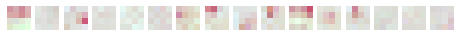


Model resolution:8x8
TRANSITION
10000/10000 [==============================] - 1019s 102ms/step - d_loss: -6.6410 - g_loss: 4.6256


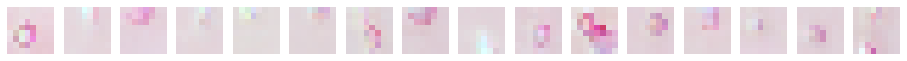

STABLE
10000/10000 [==============================] - 1036s 103ms/step - d_loss: -6.1571 - g_loss: 3.9076


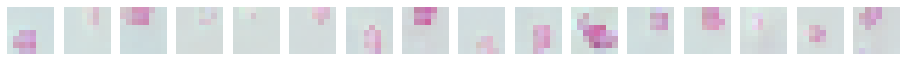


Model resolution:16x16
TRANSITION
10000/10000 [==============================] - 1129s 112ms/step - d_loss: -13.0714 - g_loss: 10.0013


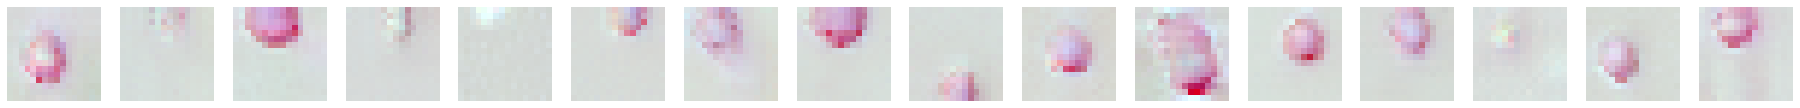

STABLE
10000/10000 [==============================] - 1181s 118ms/step - d_loss: -8.7890 - g_loss: 7.4260


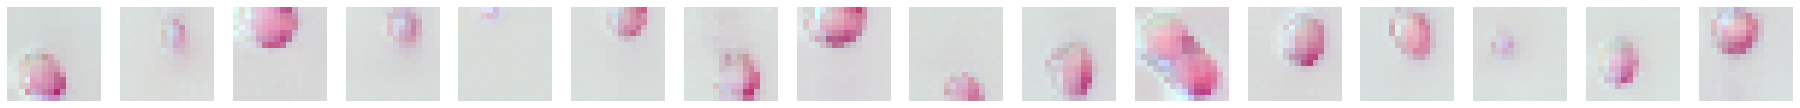


Model resolution:32x32
TRANSITION
10000/10000 [==============================] - 2122s 212ms/step - d_loss: -18.7917 - g_loss: 17.3761


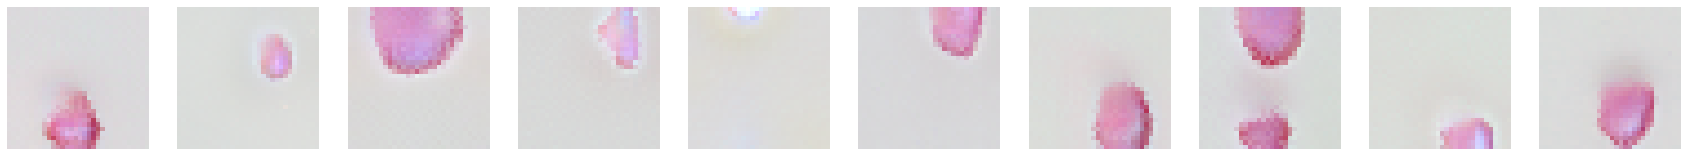

STABLE
10000/10000 [==============================] - 2112s 211ms/step - d_loss: -17.2478 - g_loss: 16.5180


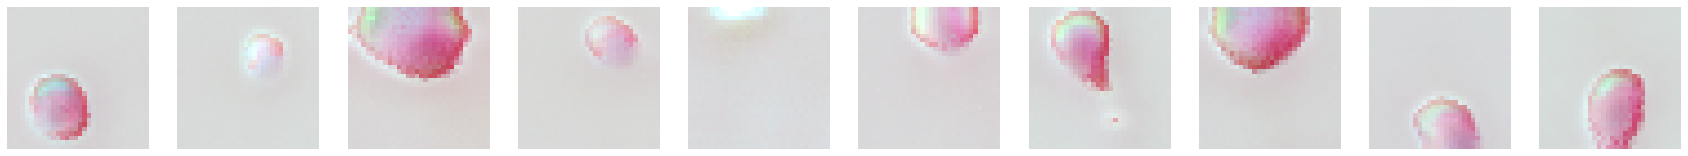


Model resolution:64x64
TRANSITION


2021-10-13 12:33:49.822569: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 268435456 exceeds 10% of free system memory.
2021-10-13 12:33:49.822640: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 268435456 exceeds 10% of free system memory.
2021-10-13 12:33:49.936028: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 268435456 exceeds 10% of free system memory.
2021-10-13 12:33:50.780265: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 268435456 exceeds 10% of free system memory.
2021-10-13 12:33:51.010421: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 268435456 exceeds 10% of free system memory.


10000/10000 [==============================] - 4535s 453ms/step - d_loss: -45.9291 - g_loss: 43.1805


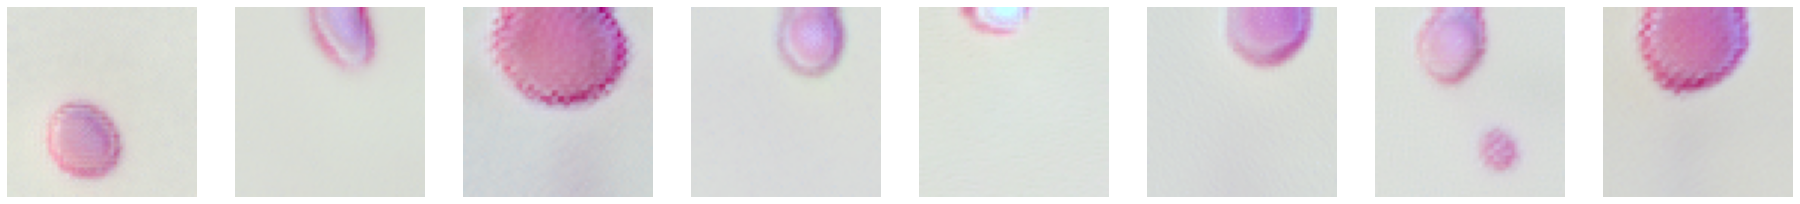

STABLE
10000/10000 [==============================] - 4529s 452ms/step - d_loss: -46.8609 - g_loss: 44.0728


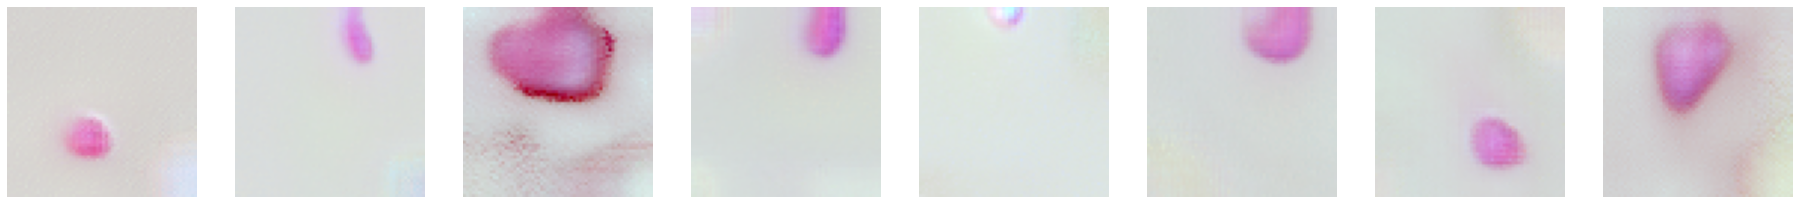


Model resolution:128x128
TRANSITION
20000/20000 [==============================] - 8671s 433ms/step - d_loss: -46.9402 - g_loss: 45.0870


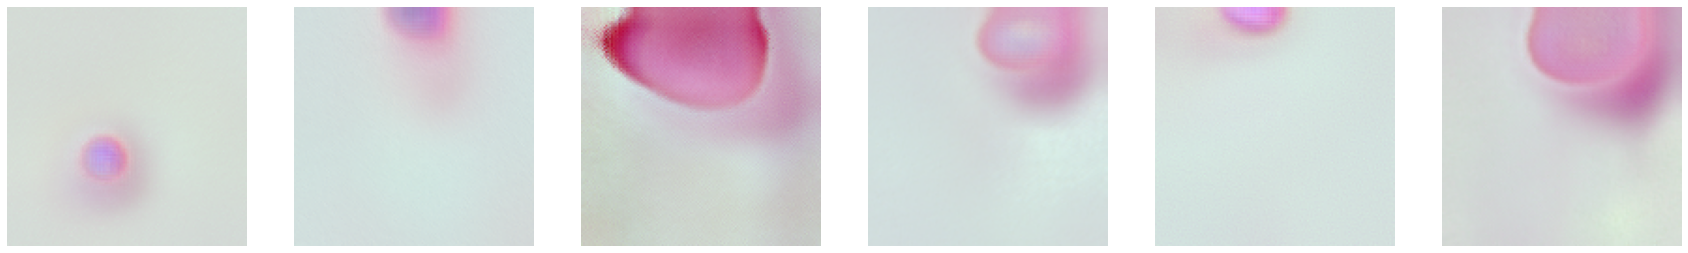

STABLE
20000/20000 [==============================] - 8661s 433ms/step - d_loss: -44.2652 - g_loss: 46.6727


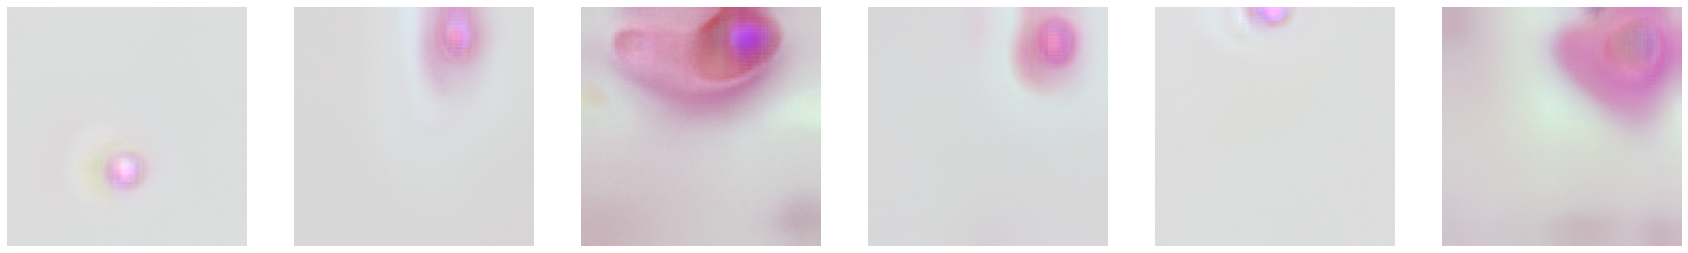


Model resolution:256x256
TRANSITION
40000/40000 [==============================] - 18071s 451ms/step - d_loss: -39.5482 - g_loss: 54.1614


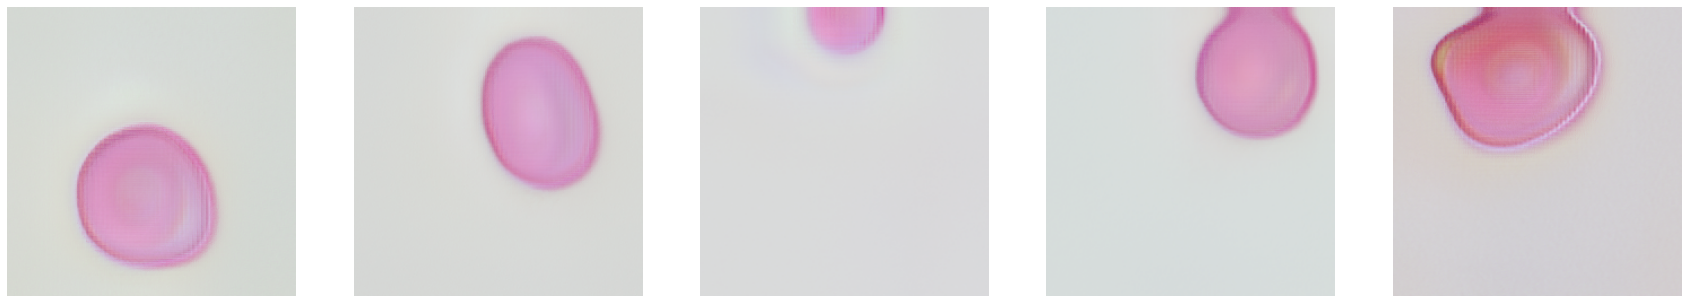

STABLE
40000/40000 [==============================] - 17996s 450ms/step - d_loss: -54.9693 - g_loss: 56.8224


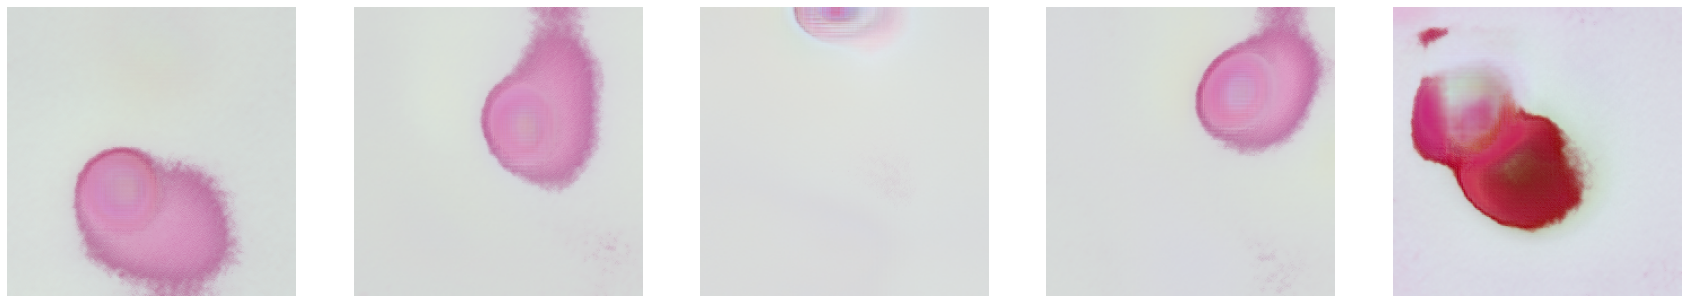


Model resolution:512x512
TRANSITION
80000/80000 [==============================] - 31867s 398ms/step - d_loss: -74.2026 - g_loss: 79.6734


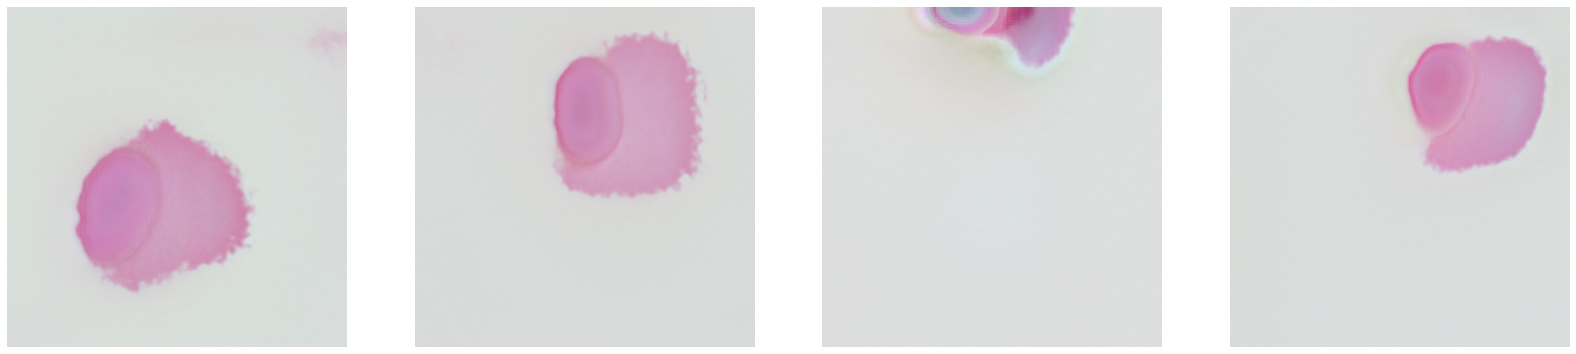

STABLE
 5571/80000 [=>............................] - ETA: 8:14:48 - d_loss: -78.1732 - g_loss: 81.2988

KeyboardInterrupt: 

In [27]:
train(start_res=4, target_res=512, steps_per_epoch=10000, display_images=True)

## Results

We can now run some inference using pre-trained 64x64 checkpoints. In general, the image
fidelity increases with the resolution. You can try to train this StyleGAN to resolutions
above 128x128 with the CelebA HQ dataset.

540549120/540534982 [==============================] - 15s 0us/step

Model resolution:128x128

Two checkpoint references resolved to different objects (<__main__.EqualizedConv object at 0x7ff5300ee490> and <keras.layers.core.Flatten object at 0x7ff53010f510>).

Two checkpoint references resolved to different objects (<__main__.EqualizedDense object at 0x7ff530188c10> and <__main__.EqualizedDense object at 0x7ff530151750>).


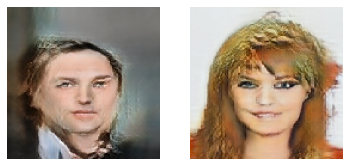

In [ ]:
url = "https://github.com/soon-yau/stylegan_keras/releases/download/keras_example_v1.0/stylegan_128x128.ckpt.zip"

weights_path = keras.utils.get_file(
    "stylegan_128x128.ckpt.zip",
    url,
    extract=True,
    cache_dir=os.path.abspath("."),
    cache_subdir="pretrained",
)

style_gan.grow_model(128)
style_gan.load_weights(os.path.join("pretrained/stylegan_128x128.ckpt"))

tf.random.set_seed(196)
batch_size = 2
z = tf.random.normal((batch_size, style_gan.z_dim))
w = style_gan.mapping(z)
noise = style_gan.generate_noise(batch_size=batch_size)
images = style_gan({"style_code": w, "noise": noise, "alpha": 1.0})
plot_images(images, 5)

## Style Mixing

We can also mix styles from two images to create a new image.

(-0.5, 383.5, 127.5, -0.5)

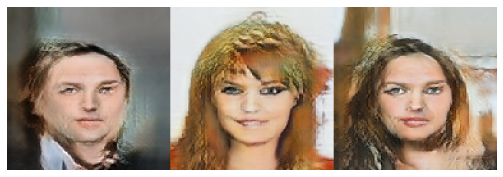

In [ ]:
alpha = 0.4
w_mix = np.expand_dims(alpha * w[0] + (1 - alpha) * w[1], 0)
noise_a = [np.expand_dims(n[0], 0) for n in noise]
mix_images = style_gan({"style_code": w_mix, "noise": noise_a})
image_row = np.hstack([images[0], images[1], mix_images[0]])
plt.figure(figsize=(9, 3))
plt.imshow(image_row)
plt.axis("off")